In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import count
    
    
class Coex_graph():
    def __init__(self, graph, name, vertex_feature_num=1, mode='train'):
        self.name = name
        self.graph = graph
        self.vertex_feature_num = vertex_feature_num
        self.mode = mode
        self.set_network_adj()
        self.set_network_features(target_feature='Periodontitis')

        self.A_hat = np.matmul(np.matmul(self.D_sqrt, self.vertex_labels),self.D_sqrt)
    
        
    def set_network_adj(self, adj=None, back_bone=True):
        if adj==None:
            self.adj = nx.convert_matrix.to_numpy_matrix(self.graph)
        
        self.D_sqrt = np.diag(np.sqrt(np.fromiter(dict(self.graph.degree).values(), float) + 1))
        back_bone = np.identity(self.adj.shape[0])
        self.adj = self.adj + back_bone
        
    def set_network_features(self, target_feature=None):
        if target_feature==None:
            self.vertex_labels = np.fromiter(dict(self.graph.nodes(data='score')).values(), float)
        else:
            self.vertex_labels = np.fromiter(dict(self.graph.nodes(data=target_feature)).values(), float)
        
    def remove_vertex_label_randomly(self, prob=0.8):
        labels = self.vertex_labels.copy()
        for i in range(len(labels)):     
            if random.random() < prob:
                 labels[i] = None
                    
        return labels
    
    def k_neighbors(self, node, k=1, sampling_num=None):
        """
        """
        i = 1
        try:
            neighbors = {i: set(random.sample(set(nx.classes.function.neighbors(self.graph, node)), sampling_num[i]))}
        except ValueError:
            print("The node {} has the less number of neighbors than {}.".format(node, sampling_num[i]))
            return None
        
        while i < k:
            neighbors[i+1] = set()
            for n in neighbors[i]:
                candidates = set(nx.classes.function.neighbors(self.graph, n))
                try:
                    sampled_nodes = set(random.sample(candidates, sampling_num[i+1]))
                except ValueError:
                    print("The node {} has the less number of neighbors than {}.".format(node, sampling_num[i+1]))
                    return None
                neighbors[i+1] = neighbors[i+1].union(sampled_nodes)
            for j in range(i):
                neighbors[i+1] = neighbors[i+1] - neighbors[j+1]
            i = i + 1
            
        return neighbors        
       
    def feed_data_load(self, node, node_nums=None):
        sampled_nodes = self.neighbor_sampling(node, node_nums[0])
        if sampled_nodes == None:
            return None
        
        depth1_nodes = list(sampled_nodes)
        self.node_list = []
        self.node_list = [node] + depth1_nodes
        self.center = node
        self.first_n = depth1_nodes
        
        depth2_nodes = []
        for i in depth1_nodes:
            sampled_nodes = self.neighbor_sampling(i,node_nums[1])
            if sampled_nodes == None:
                return None
            self.node_list += list(sampled_nodes)
            depth2_nodes.append(list(sampled_nodes))
            
        depth1_features = [ list(self.graph.nodes(data=True)[x].values()) for x in depth1_nodes ]
        depth2_features = []
        for i in depth2_nodes:
            depth2_features.append([list(self.graph.nodes(data=True)[x].values()) for x in i])
        
        depth1_edges = []
        for i in depth1_nodes:
            depth1_edges.append(self.graph[node][i]['weight'])
            
        depth2_edges = []
        for i, j in zip(depth1_nodes, depth2_nodes):
            edge_weights = []
            for k in j:
                edge_weights.append(self.graph[i][k]['weight'])
            depth2_edges.append(edge_weights)
        
        depth1_edges = np.array(depth1_edges)
        depth2_edges = np.array(depth2_edges)
        depth1_features = np.array(depth1_features)
        depth2_features = np.array(depth2_features)
        
        return depth1_features, depth1_edges, depth2_features, depth2_edges
       
    def vis_sampled_nodes(self):
        node_list = self.node_list
        print(len(node_list))
        k = self.graph.subgraph(node_list)
        visualize_network(k, self.center, self.first_n)
        
    
    def neighbor_sampling(self, node, sampling_num=None):
        candidates = set(nx.classes.function.neighbors(self.graph, node))
        try:
            sampled_nodes = set(random.sample(candidates, sampling_num))
        except ValueError:
            #print("The node {} has the less number of neighbors than {}.".format(node, sampling_num))
            return None
        
        return sampled_nodes

    def random_node(self):
        return random.choice(list(self.graph.nodes()))

In [7]:
import progressbar as pgb
import pandas as pd
import networkx as nx
import random
import math

def load_humanbase_coex_data(file_name):
    """
    """
    target_file = open(file_name, 'r')
    target_raws = target_file.readlines()
    print("Reading coexpression data {}. . . .".format(file_name))
    target_list = list(map(lambda x : x.rstrip().split('\t') , target_raws))
    
    print("Edge building . . . . .")
    coex_graph = nx.Graph()
    bar = pgb.ProgressBar(max_value=len(target_raws))
    prog = 0
    for i in target_list:
        try:
            coex_graph.add_edge(i[0], i[1], weight=float(i[2]))
        except:
            print("{} is not valid float".format(i[2]))
        prog += 1
        bar.update(prog)
    
    return coex_graph


def update_disease_features_coex(file_name, coex_graph):
    """
    """
    genes = pd.read_csv(file_name)
    genes = genes.sort_values(by=['geneid'])
    disease_name = file_name.rsplit('/')[1].split('_')[0]
    
    print("Update features from {}. . .".format(file_name))
    bar = pgb.ProgressBar(max_value=len(coex_graph.nodes))
    prog = 0
    
    for v in coex_graph.nodes:
        ## Search matched geneid
        check_in = False
        start = 0
        end = len(genes) - 1
        mid = int((start+end)/2)
        while (end-start) > 1:
            mid = int((start + end)/2)
            if int(v) > genes['geneid'].iloc[mid]:
                start = mid
            elif int(v) < genes['geneid'].iloc[mid]:
                end = mid
            else:
                nx.set_node_attributes(coex_graph, {v :{disease_name : float(genes['score'].iloc[mid])}})
                check_in = True
                break
        if not check_in:
            nx.set_node_attributes(coex_graph, {v :{disease_name : 0.0}})
            check_in = False
        prog += 1
        bar.update(prog)
    
    return coex_graph


def update_gene_features_coex(file_name, coex_graph):
    gene_table = pd.read_table(file_name)[['geneId', 'DSI', 'DPI']].drop_duplicates().dropna()
    
    print("Update DSI, DPI from {} . . .".format(file_name))
    bar = pgb.ProgressBar(max_value=len(coex_graph.nodes))
    prog = 0
    
    missed_nodes = []
    for v in coex_graph.nodes:
        check_in = False
        start = 0
        end = len(gene_table)
        mid = int((start+end)/2)
        while (end-start) > 1:
            mid = int((start+end)/2)
            if int(v) > gene_table['geneId'].iloc[mid]:
                start = mid
            elif int(v) < gene_table['geneId'].iloc[mid]:
                end = mid
            else:
                nx.set_node_attributes(coex_graph,
                                      {v: {'dpi' : float(gene_table['DPI'].iloc[mid]),
                                           'dsi': float(gene_table['DSI'].iloc[mid])}})
                check_in = True
                break
        if not check_in:
            #nx.set_node_attributes(coex_graph,{v: {'dpi' : 0.5, 'dsi': 0.5}})
            missed_nodes.append(v)
            check_in = False
            
        prog += 1
        bar.update(prog)
    for n in missed_nodes:
        coex_graph.remove_node(n)
        
    return coex_graph



def visualize_network(net, center, first, edge_width_scale=1):
    """
    
    """
    #i = 0
    #for w in weight_set:
    #    print(i)
    #    weighted_edges = [(node1, node2) for (node1, node2, edge_attr) in net.edges(data=True) if edge_attr['weight']==w]
    #    width = edge_width_scale*w*len(net)/sum(weight_set)
    #    nx.draw_networkx_edges(net, pos, edge_list=weighted_edges)
    #    i += 1
    second = list(set(net.nodes()) - set(center) - set(first))
    
    nodes = net.nodes()
    groups = nx.get_node_attributes(net,'diabetes').values()
    mapping = dict(zip(sorted(groups), count()))
    colors = [mapping[net.node[n]['diabetes']] for n in nodes]
    
    #plt.figure(figsize=(30,30))
    pos = nx.spring_layout(net)
    ec = nx.draw_networkx_edges(net, pos, alpha=0.3)#, edge_list=weighted_edges)
    #nx.draw_networkx_nodes(net, pos, nodelist=second, node_size=20, node_color='r')
    #nx.draw_networkx_nodes(net, pos, nodelist=[center], node_size=20, node_color='b')
    #nx.draw_networkx_nodes(net, pos, nodelist=first, node_size=20, node_color='g')
    print(mapping)
    nc = nx.draw_networkx_nodes(net, pos, nodelist=nodes, node_color=colors, node_size='100',
                           cmap=plt.cm.jet, with_labels=False)
    
    plt.colorbar(nc)
    plt.savefig('visual_graph')
    plt.show()


In [30]:
graph = load_humanbase_coex_data("data/tooth_top_0.3")

### Give score features that represent relations with a disease for each vertex.
#graph = update_disease_features_coex("data/Periodontitis_genes.csv", graph)
graph = update_disease_features_coex("data/diabetes_genes.csv", graph)
#graph = update_disease_features_coex("data/rheumatoid_genes.csv", graph)
graph = update_gene_features_coex("data/all_gene_disease_associations.tsv", graph)

coex_graph = Coex_graph(graph, "perio_graph", vertex_feature_num=3)

Reading coexpression data data/tooth_top_0.3. . . .


  0% (16185 of 2074445) |                | Elapsed Time: 0:00:00 ETA:   0:01:51

Edge building . . . . .


  7% (1413 of 18594) |#                  | Elapsed Time: 0:00:00 ETA:   0:00:02

Update features from data/diabetes_genes.csv. . .


 98% (18359 of 18594) |################# | Elapsed Time: 0:00:02 ETA:   0:00:00/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  5% (942 of 18594) |#                   | Elapsed Time: 0:00:00 ETA:   0:00:03

Update DSI, DPI from data/all_gene_disease_associations.tsv . . .


 98% (18359 of 18594) |################# | Elapsed Time: 0:00:03 ETA:   0:00:00

321
{0.0: 274, 0.01: 285, 0.02: 290, 0.04: 291, 0.05: 294, 0.07: 295, 0.1: 299, 0.2: 301, 0.36: 303, 0.4: 304, 0.42: 305, 0.5: 307}


TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

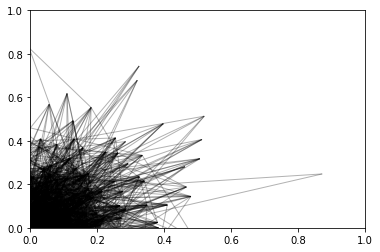

In [17]:
while coex_graph.feed_data_load(coex_graph.random_node(),(20, 15)) == None:
    pass
coex_graph.

In [ ]:
coex_graph.graph.node['']

In [34]:
a = list(dict(coex_graph.graph.degree).values())
sum(a)/len(a)
a

[862,
 371,
 449,
 1331,
 40,
 407,
 100,
 173,
 16,
 295,
 873,
 340,
 145,
 608,
 231,
 323,
 386,
 357,
 205,
 377,
 1534,
 357,
 528,
 300,
 176,
 119,
 560,
 316,
 852,
 325,
 881,
 382,
 1427,
 1081,
 317,
 120,
 262,
 1232,
 671,
 633,
 344,
 334,
 603,
 349,
 231,
 232,
 260,
 196,
 433,
 585,
 421,
 187,
 230,
 260,
 138,
 395,
 88,
 345,
 232,
 647,
 620,
 531,
 478,
 584,
 292,
 355,
 184,
 210,
 202,
 609,
 386,
 395,
 440,
 978,
 471,
 396,
 258,
 42,
 705,
 480,
 327,
 105,
 325,
 75,
 245,
 845,
 65,
 363,
 1536,
 119,
 916,
 484,
 352,
 336,
 541,
 313,
 3,
 90,
 43,
 25,
 504,
 753,
 465,
 1183,
 707,
 178,
 845,
 510,
 615,
 404,
 1024,
 849,
 636,
 696,
 131,
 570,
 204,
 143,
 301,
 268,
 206,
 943,
 453,
 276,
 352,
 676,
 292,
 1503,
 404,
 387,
 911,
 1025,
 756,
 1004,
 506,
 511,
 679,
 504,
 696,
 601,
 780,
 201,
 1046,
 847,
 352,
 343,
 1032,
 650,
 99,
 150,
 848,
 823,
 179,
 91,
 172,
 274,
 854,
 135,
 359,
 887,
 287,
 929,
 606,
 991,
 370,
 4238,
 13